Demonstrate segmentation by SAM

In [1]:
results_path = 'C:\\Users\\espen\\Documents\\work\\salmon_welfare_monitoring\\data\\SaBRE2_data\\associator\\BoostCompTrack\\output\\salmon_tracking\\analysis2\\MOT_results.txt'

In [ ]:
# Code paths
import os
import sys
sys.path.append(os.path.split(os.getcwd())[0] + '\\helpers')
sys.path.append(os.path.split(os.getcwd())[0] + '\\associator\\CompTrack\\')
sys.path.append(os.path.split(os.getcwd())[0] + '\\associator\\BoostTrack\\')
sys.path.append(os.path.split(os.getcwd())[0] + '\\associator\\BoostTrack\\external')
import numpy as np
from file_utils import load_txt_data_for_eval 
from comp_utils import get_salmon_ID_and_comp_type_from_comp_ID, get_comp_id_from_salmon_ID_and_comp_type
from draw_utils import annotate_frame
import keybox_utils as ku
import cv2
import matplotlib.pyplot as plt
import yaml

from segment_anything import sam_model_registry, SamPredictor


In [3]:
trackers = load_txt_data_for_eval(results_path)[:,:11]

In [4]:
with open('\\'.join(results_path.split('\\')[:-1]) + '\\config.yml', 'r') as f:
    config = yaml.safe_load(f)

In [5]:
def in_list(lst, item):
    return item in lst

In [6]:
# Find IDs of sufficcient size
trackers[:,1],_ = get_salmon_ID_and_comp_type_from_comp_ID(trackers[:,1].astype(float).astype(int),9)
salmon_dets = trackers[trackers[:,10] == 'salmon']
salmon_size = salmon_dets[:,4].astype(float)*salmon_dets[:,5].astype(float)
large_salmon = salmon_dets[salmon_size > 100000]
large_salmon_id = np.array(list(set(large_salmon[:,1]))).astype(int)
tracker_ids = trackers[:,1].astype(int)
idces = [in_list(large_salmon_id,x) for x in tracker_ids]
large_dets = trackers[idces,:]

In [7]:
# Extract frame data
frame_num = 140
large_dets_frame = large_dets[large_dets[:,0] == str(frame_num)]

cap = cv2.VideoCapture(config['video_path'])
cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_num))
success, frame = cap.read()

In [ ]:
def annotate_frame_mot(mot_targets, frame, frame_num, config):
    config['bp_bbox_thickness'] = 8
    config['salmon_bbox_thickness'] = 10
    comp_type_ints = np.array([config['components'].index(l) for l in mot_targets[:,10:]]).reshape(mot_targets.shape[0], 1)
    comp_ids = np.array([get_comp_id_from_salmon_ID_and_comp_type(int(id), int(comp),9) for id, comp in zip(mot_targets[:,1:2], comp_type_ints)]).reshape(mot_targets.shape[0], 1)
    function_targets = np.hstack([np.array([ku.xywh2xyxy(b.astype(float).astype(int)) for b in mot_targets[:,2:6]]), comp_ids, mot_targets[:,6:7], comp_type_ints]).astype(float)
    annot_frame = annotate_frame(function_targets, frame, frame_num, config, True, skeleton_line_thickness=4, font_scale=4, include_id_text = True)
    return annot_frame
annot_frame = annotate_frame_mot(large_dets_frame, frame.copy(), frame_num, config)

C:\Users\espen\AppData\Local\Temp\ipykernel_16028\897783166.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  comp_ids = np.array([get_comp_id_from_salmon_ID_and_comp_type(int(id), int(comp),9) for id, comp in zip(mot_targets[:,1:2], comp_type_ints)]).reshape(mot_targets.shape[0], 1)


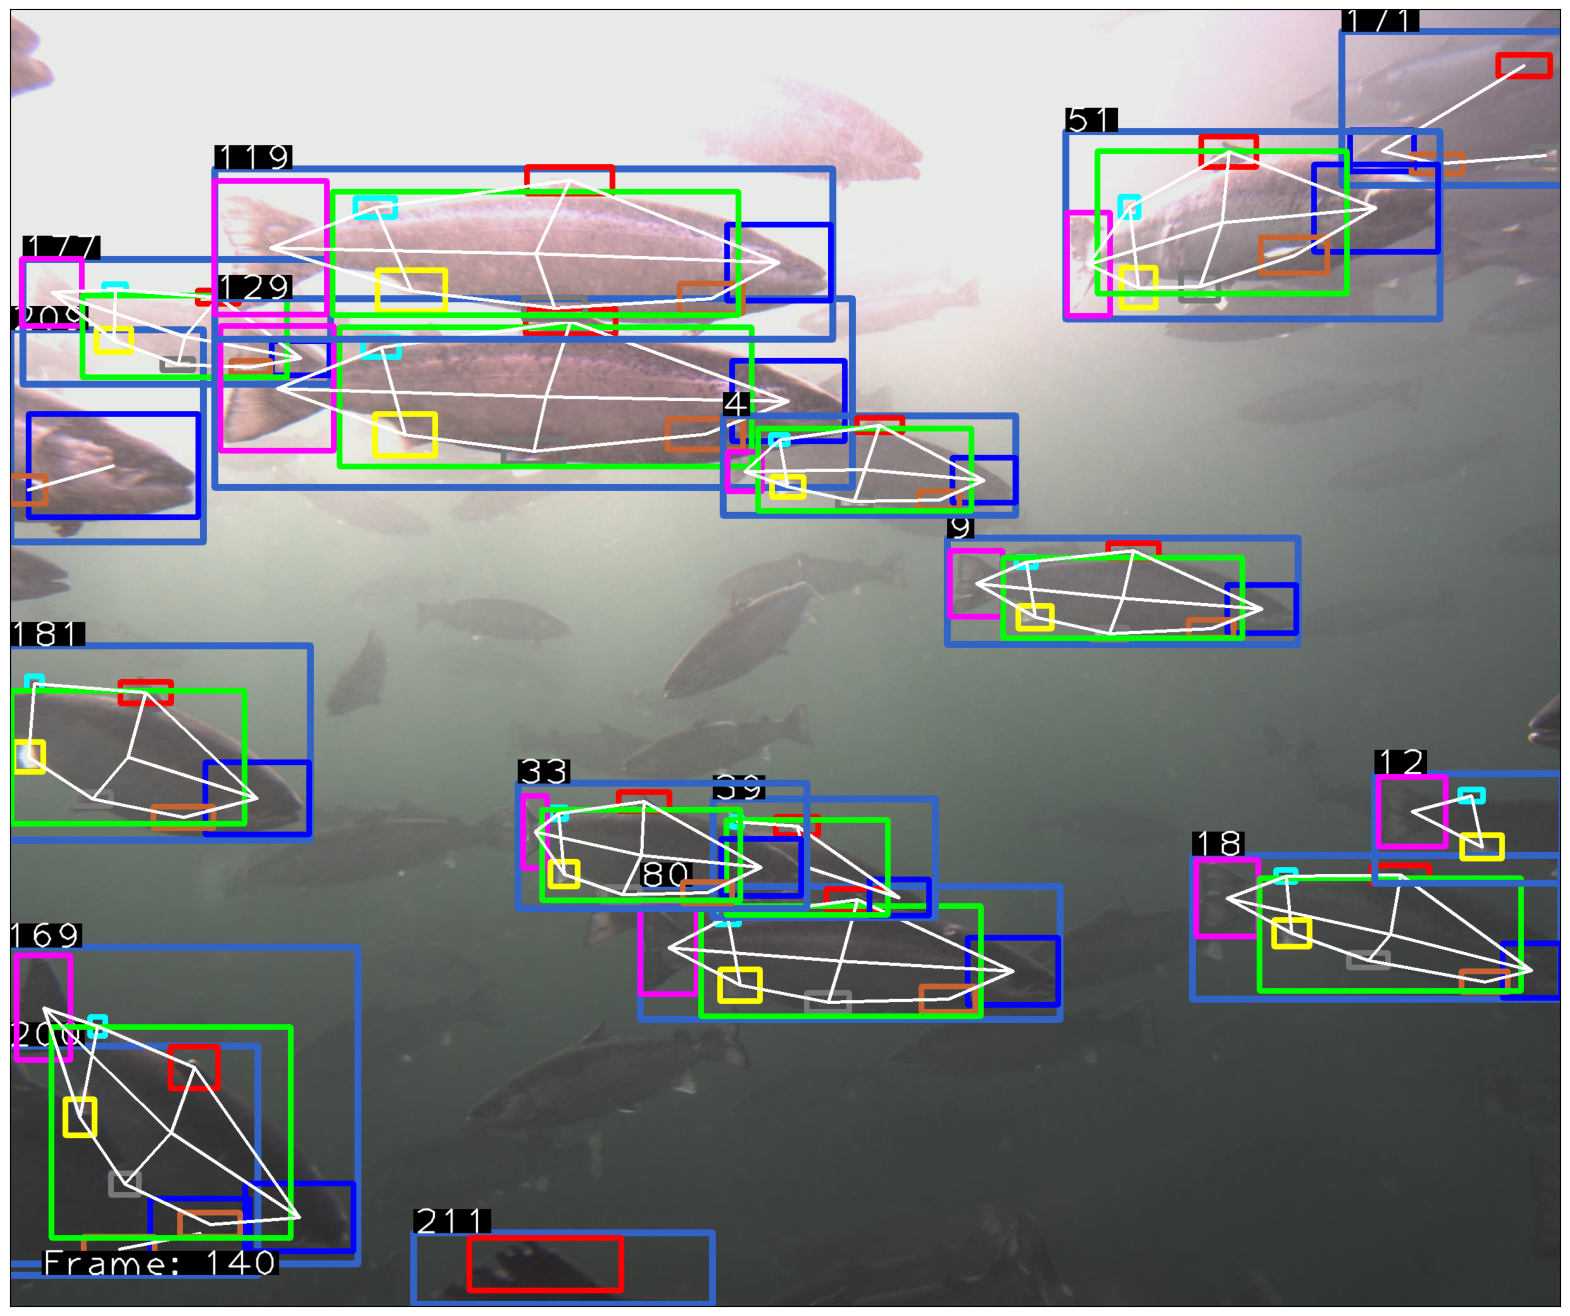

In [9]:
def plot_frame(frame):
    fig, ax = plt.subplots(1,1,figsize = (20,20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plot_frame(annot_frame)

In [ ]:
sam_checkpoint = "C:\\Users\\espen\\Documents\\work\\salmon_welfare_monitoring\\data\\experimental\\sam\\checkpoint\\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(frame)

In [11]:
def construct_masks(large_dets_frame):
    masks_dict = {}
    for id in set(large_dets_frame[:,1]):
        id_dict = {}
        id_dets = large_dets_frame[large_dets_frame[:,1]==id]
        id_dets = id_dets[id_dets[:,10] != 'body']
        xywhs = id_dets[:,2:6].astype(float).astype(int)
        xyxys = np.array([ku.xywh2xyxy(list(b)) for b in xywhs]).astype(int)
        classes = id_dets[:,10]
        for xyxy, c in zip(xyxys, classes):
            mask, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box = xyxy,
                multimask_output=False,
            )
            id_dict[c] = mask[0,:,:]
        masks_dict[id] = id_dict
    return masks_dict
masks_dict = construct_masks(large_dets_frame)

In [12]:
def generate_annotated_video_frame(frame, masks_dict, config, background = 'blank'):
    if background == 'blank':
        output_frame = np.ones(frame.shape).astype(np.uint8)*255
    elif background == 'original':
        output_frame = frame.copy()

    for id in masks_dict.keys():
        for c in masks_dict[id].keys():
            mask = masks_dict[id][c].reshape(frame.shape[0], frame.shape[1])
            contours = cv2.findContours(mask.astype(np.uint8)*255, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            if background == 'blank':
                output_frame[mask] = frame[mask].copy()
            cv2.drawContours(output_frame, contours, -1, config['component_colors'][c], 5) 

    return output_frame

In [13]:
annot_frame = generate_annotated_video_frame(frame, masks_dict, config, background='blank')

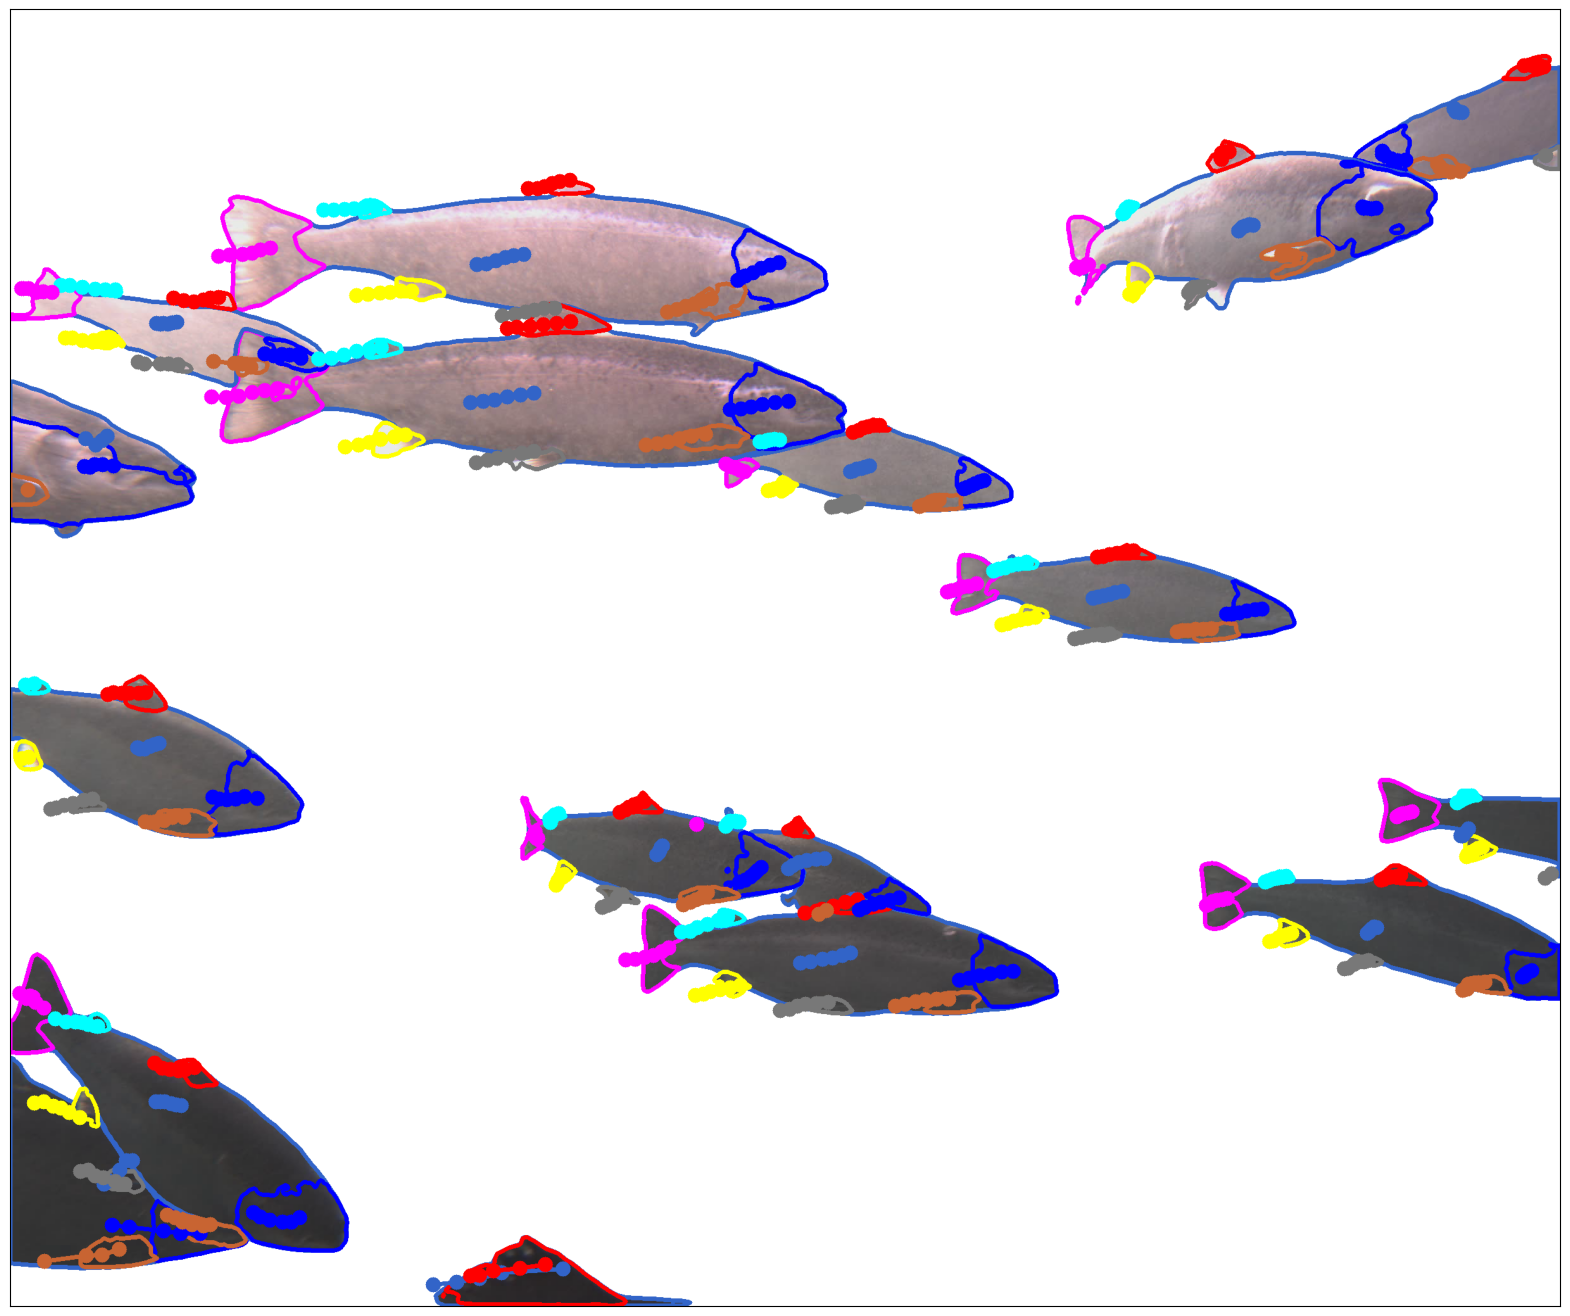

In [14]:
def plot_previous_tracks(annot_frame, large_dets_frame, trackers, frame_num):
    ids = list(set(large_dets_frame[:,1]))
    for id in ids:
        earlier_tracks = trackers[trackers[:,1]==id]
        trk = {k:[] for k in config['components']}

        for temp_frame_num in range(frame_num-5,frame_num+1):
            earlier_tracks_frame = earlier_tracks[earlier_tracks[:,0]==str(temp_frame_num)]
            if earlier_tracks_frame.shape[0] > 0:
                for trackunit in earlier_tracks_frame:
                    if trackunit[-1] != 'body':
                        trk[trackunit[-1]].append([int(float(trackunit[2])), int(float(trackunit[3]))])
        
        for k, val in trk.items():
            for i in range(len(val)):
                if i < len(val)-1:
                    cv2.line(annot_frame, (val[i][0], val[i][1]), (val[i+1][0], val[i+1][1]), config['component_colors'][k], 6)
                cv2.circle(annot_frame, (val[i][0], val[i][1]), 12, config['component_colors'][k], -1)

    return annot_frame
aframe = plot_previous_tracks(annot_frame.copy(), large_dets_frame, trackers, frame_num)

plot_frame(aframe)